In [1]:
# Python 3.13
# If needed in a fresh env:
#   pip install "pymc>=5.21" "arviz>=0.17" "numpy>=2" "pandas>=2.2"
from pytensor.tensor.variable import TensorVariable
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# ---- 1) Get synthetic data from your helpers ----
from bayes_tools.helpers.synthetic_data_helpers import (
    make_hierarchical_ou_dataset,
    aggregate_to_parent,
)

# Build OU-level monthly panel
df_ou = make_hierarchical_ou_dataset(
    n_regions=1,
    n_sites_per_region=3,
    n_ous_per_site=4,
    n_years=1,
    wave_months=(6, 12),
    wave_missing_prob=0.,
    seed=7,
)

# (Optional) aggregate to parent level (e.g., 'site' or 'region')
# df_site = aggregate_to_parent(df_ou, level="site")

# We'll model at the OU level:
df = df_ou.copy()

In [2]:
df.shape

(144, 8)

In [3]:
df.head()

,region_id,site_id,ou_code,date,productivity,fte_operational,survey_score,n_respondents
0,R1,S1-1,OU1-1-1,2020-01-01,86.563754,53.345425,NaN,NaN
1,R1,S1-1,OU1-1-1,2020-02-01,104.052596,52.654650,NaN,NaN
2,R1,S1-1,OU1-1-1,2020-03-01,98.858177,57.767779,NaN,NaN
3,R1,S1-1,OU1-1-1,2020-04-01,105.080048,56.394493,NaN,NaN
4,R1,S1-1,OU1-1-1,2020-05-01,96.044476,54.231160,NaN,NaN


In [4]:
df[df["survey_score"].notna()].groupby(["ou_code", "date"])[["survey_score", "productivity"]].mean()

survey_score  productivity
ou_code date                                  
OU1-1-1 2020-06-01     53.866623     98.668251
        2020-12-01     55.462315     91.060807
OU1-1-2 2020-06-01     54.500832     87.524932
        2020-12-01     59.795317     90.346527
OU1-1-3 2020-06-01     54.301297     73.916940
        2020-12-01     52.585482     78.163741
OU1-1-4 2020-06-01     59.501987     90.381472
        2020-12-01     57.664388     80.923740
OU1-2-1 2020-06-01     54.060637    155.977044
        2020-12-01     52.992024    138.553519
OU1-2-2 2020-06-01     59.604599    112.750174
        2020-12-01     61.309125    112.529496
OU1-2-3 2020-06-01     55.428690    143.300953
        2020-12-01     58.349244    133.213233
OU1-2-4 2020-06-01     58.731076    133.088820
        2020-12-01     58.866422    146.625824
OU1-3-1 2020-06-01     57.968265     80.220839
        2020-12-01     57.777761     87.236028
OU1-3-2 2020-06-01     62.620604    125.079835
        2020-12-01     54.948057    124.041752
OU1-3-3 2020-06-01     59.251579     86.280454
        2020-12-01     58.512415     79.147839
OU1-3-4 2020-06-01     57.073635     86.930447
        2020-12-01     53.051819     81.238700

In [5]:
df[df["survey_score"].notna()].groupby(["ou_code", "date"])[["survey_score", "productivity"]].mean()

survey_score  productivity
ou_code date                                  
OU1-1-1 2020-06-01     53.866623     98.668251
        2020-12-01     55.462315     91.060807
OU1-1-2 2020-06-01     54.500832     87.524932
        2020-12-01     59.795317     90.346527
OU1-1-3 2020-06-01     54.301297     73.916940
        2020-12-01     52.585482     78.163741
OU1-1-4 2020-06-01     59.501987     90.381472
        2020-12-01     57.664388     80.923740
OU1-2-1 2020-06-01     54.060637    155.977044
        2020-12-01     52.992024    138.553519
OU1-2-2 2020-06-01     59.604599    112.750174
        2020-12-01     61.309125    112.529496
OU1-2-3 2020-06-01     55.428690    143.300953
        2020-12-01     58.349244    133.213233
OU1-2-4 2020-06-01     58.731076    133.088820
        2020-12-01     58.866422    146.625824
OU1-3-1 2020-06-01     57.968265     80.220839
        2020-12-01     57.777761     87.236028
OU1-3-2 2020-06-01     62.620604    125.079835
        2020-12-01     54.948057    124.041752
OU1-3-3 2020-06-01     59.251579     86.280454
        2020-12-01     58.512415     79.147839
OU1-3-4 2020-06-01     57.073635     86.930447
        2020-12-01     53.051819     81.238700

In [6]:
df.isna().sum()

region_id            0
site_id              0
ou_code              0
date                 0
productivity         0
fte_operational      0
survey_score       120
n_respondents      120
dtype: int64

In [7]:

# ---- 2) Basic feature prep ----
# indices
df = df_ou.copy()
df = df.sort_values(["ou_code", "date"]).reset_index(drop=True)
ou_codes = df["ou_code"].astype("category")
ou_idx = ou_codes.cat.codes.to_numpy().astype("int32")

# time index (month panel)
dates = pd.to_datetime(df["date"])
unique_months = np.sort(dates.unique())
month_to_idx = {m: i for i, m in enumerate(unique_months)}
time_idx = np.array([month_to_idx[d] for d in dates], dtype="int32")
T = len(unique_months)
G = ou_codes.cat.categories.size

# outcomes and predictors
y_raw = df["productivity"].to_numpy().astype("float64")
# log-transform to make noise closer to Gaussian / stabilize variance
y = np.log(y_raw).astype("float64")

x_obs = df["survey_score"].to_numpy().astype("float64")  # may contain NaN
n_resp = df["n_respondents"].to_numpy()                  # NaN where no survey
n_resp_filled = np.where(np.isnan(n_resp), 0.0, n_resp).astype("float64")
has_survey = ~np.isnan(x_obs)
idx_obs = np.flatnonzero(has_survey)

# standardization helpers (kept simple; you can swap for robust scaling)
def zscore(a: np.ndarray):
    m = np.nanmean(a)
    s = np.nanstd(a)
    s = s if s > 0 else 1.0
    return (a - m) / s, m, s

y_z, y_mean, y_sd = zscore(y)      # target
x_z = x_obs.copy()
if np.isfinite(x_obs[idx_obs]).any():
    x_z, x_mean, x_sd = zscore(x_obs)
else:
    # fallback if synthetic happens to miss every survey (unlikely)
    x_mean, x_sd = 0.0, 1.0
    x_z = (x_obs - x_mean) / x_sd

# ---- 3) PyMC model ----
with pm.Model() as model:
    # --- Global means for OU intercept/slope (on log-productivity scale) ---
    mu_alpha = pm.Normal("mu_alpha", 0.0, 1.0)
    mu_beta  = pm.Normal("mu_beta",  0.0, 0.5)

    # --- Correlated OU effects: [alpha, beta] via LKJ-Cholesky for robustness ---
    L_ou, corr_ab, sds_ab = pm.LKJCholeskyCov(
        "L_ou",
        n=2,
        eta=2.0,
        sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True,
        store_in_trace=True,
    ) # type: ignore
    L_ou: TensorVariable = L_ou
    assert isinstance(L_ou, TensorVariable) and isinstance(corr_ab, TensorVariable) and isinstance(sds_ab, TensorVariable)
    z = pm.Normal("z", 0.0, 1.0, size=(G, 2))          # Gx2
    ab = pt.dot(z, L_ou.T)                              # Gx2
    alpha_ou = pm.Deterministic("alpha_ou", mu_alpha + ab[:, 0])
    beta_ou  = pm.Deterministic("beta_ou",  mu_beta  + ab[:, 1])

    # --- Time fixed effects (centered) for the outcome ---
    time_raw = pm.Normal("time_raw", 0.0, 1.0, shape=T)
    time_eff = time_raw - pt.mean(time_raw)

    # --- Latent survey process x* (z-scored scale) ---
    # OU-level mean for x*
    mu_x = pm.Normal("mu_x", 0.0, 1.0)
    sigma_mu_x = pm.HalfNormal("sigma_mu_x", 1.0)
    mu_x_ou = pm.Normal("mu_x_ou", mu_x, sigma_mu_x, shape=G)

    # Time effect for x* (optional; helps interpolate sparse waves)
    time_x_raw = pm.Normal("time_x_raw", 0.0, 1.0, shape=T)
    time_x_eff = time_x_raw - pt.mean(time_x_raw)

    # Latent x* per OU-month with residual variance
    sigma_x = pm.HalfNormal("sigma_x", 1.0)
    
    # gamma_time_x = pm.Normal("gamma_time_x", 0.0, 0.3)

    x_latent = pm.Normal(
        "x_latent",
        # mu_x_ou[ou_idx] + gamma_time_x * time_x_eff[time_idx],  # small/shrunk time wiggle
        mu_x_ou[ou_idx] + 0.2 * time_x_eff[time_idx],
        sigma_x,
        shape=y_z.shape[0],
    )

    # --- Measurement model where survey is observed ---
    # Downweight by sqrt(n_resp): larger n -> lower noise
    # Guard against n=0: clamp minimum effective n to 1.
    n_eff = pt.clip(pt.sqrt(pt.maximum(pt.as_tensor_variable(n_resp_filled), 1.0)), 1.0, 1000.0) # type: ignore
    sigma_meas_base = pm.HalfNormal("sigma_meas_base", 1.0)
    sigma_meas = sigma_meas_base / n_eff

    # Only impose likelihood where survey actually observed
    pm.Normal(
        "survey_obs",
        mu=x_latent[idx_obs],
        sigma=sigma_meas[idx_obs],
        observed=(x_z[idx_obs]),
    )

    # --- Outcome model: log productivity (z-scored) ---
    # Residual noise
    sigma_y = pm.HalfNormal("sigma_y", 0.5)

    mu_y = alpha_ou[ou_idx] + time_eff[time_idx] + beta_ou[ou_idx] * x_latent
    y_like = pm.Normal("y_like", mu=mu_y, sigma=sigma_y, observed=y_z)

    # --- Helpful deterministics for interpretation on original scales ---
    pm.Deterministic("corr_alpha_beta", corr_ab[0, 1])
    pm.Deterministic("beta_global", mu_beta)

     # ---- 4) Sample ----
    idata = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=0.9,
        random_seed=7,
        progressbar=True,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, mu_beta, L_ou, z, time_raw, mu_x, sigma_mu_x, mu_x_ou, time_x_raw, sigma_x, x_latent, sigma_meas_base, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
x_post_mean = idata.posterior["x_latent"].mean(("chain","draw")).values
np.corrcoef(x_post_mean[idx_obs], x_z[idx_obs])[0,1]   # expect high

np.float64(0.97981413533718)

Alpha per OU (posterior mean and 90% HDI):


,mean,hdi_5%,hdi_95%
ou_code,,,
OU1-1-1,-0.351,-0.540,-0.125
OU1-1-2,-0.500,-0.655,-0.344
OU1-1-3,-1.231,-1.572,-0.902
OU1-1-4,-0.603,-0.793,-0.398
OU1-2-1,1.433,1.054,1.785
OU1-2-2,0.405,0.096,0.671
OU1-2-3,1.179,1.004,1.352
OU1-2-4,1.337,1.095,1.594
OU1-3-1,-0.773,-0.970,-0.592



Beta per OU (posterior mean and 90% HDI):


,mean,hdi_5%,hdi_95%
ou_code,,,
OU1-1-1,0.023,-0.322,0.427
OU1-1-2,0.032,-0.398,0.410
OU1-1-3,0.029,-0.394,0.464
OU1-1-4,0.037,-0.335,0.475
OU1-2-1,-0.003,-0.482,0.402
OU1-2-2,0.015,-0.404,0.383
OU1-2-3,-0.009,-0.477,0.501
OU1-2-4,-0.011,-0.550,0.471
OU1-3-1,0.019,-0.452,0.514


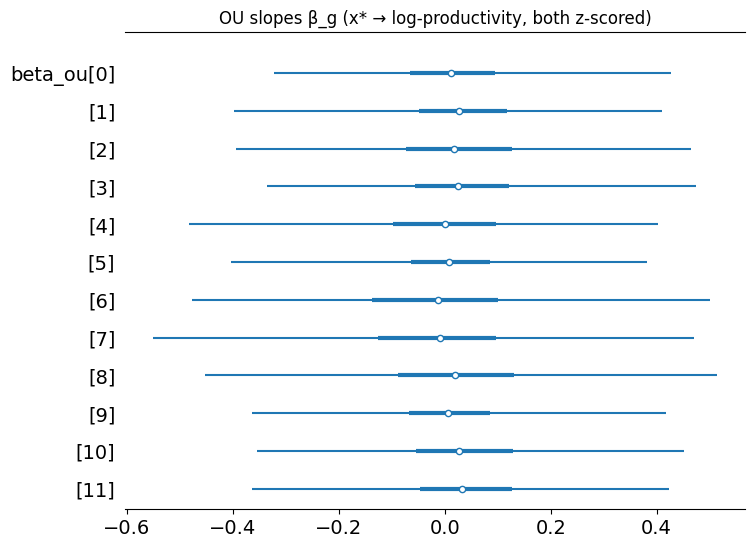

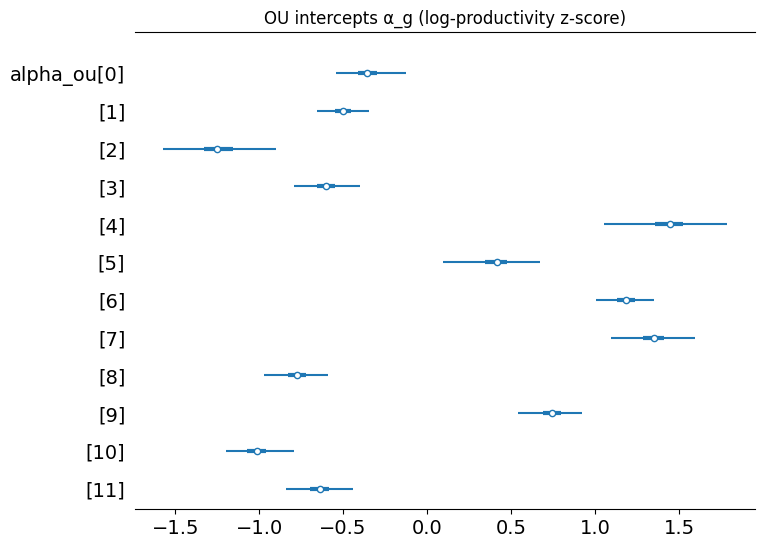

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, arviz as az

# Nice labels for OUs
ou_labels = pd.Index(pd.Categorical(df["ou_code"]).categories.astype(str), name="ou_code")

# Quick tables
summ_alpha = az.summary(idata, var_names=["alpha_ou"], hdi_prob=0.9)
summ_beta  = az.summary(idata, var_names=["beta_ou"],  hdi_prob=0.9)

# Attach OU codes to summaries (indices like 'beta_ou[0]')
def add_ou_labels(summ, ou_labels):
    lab = []
    for idx in summ.index:
        i = int(idx.split("[")[1].rstrip("]"))
        lab.append(ou_labels[i])
    summ = summ.assign(ou_code=lab).set_index("ou_code")
    return summ

summ_alpha = add_ou_labels(summ_alpha, ou_labels)
summ_beta  = add_ou_labels(summ_beta,  ou_labels)

print("Alpha per OU (posterior mean and 90% HDI):")
display(summ_alpha[["mean","hdi_5%","hdi_95%"]])
print("\nBeta per OU (posterior mean and 90% HDI):")
display(summ_beta[["mean","hdi_5%","hdi_95%"]])

# Forest plots
az.plot_forest(idata, var_names=["beta_ou"], combined=True, hdi_prob=0.9, figsize=(8, 0.35*len(ou_labels)+2))
plt.title("OU slopes β_g (x* → log-productivity, both z-scored)")
plt.show()

az.plot_forest(idata, var_names=["alpha_ou"], combined=True, hdi_prob=0.9, figsize=(8, 0.35*len(ou_labels)+2))
plt.title("OU intercepts α_g (log-productivity z-score)")
plt.show()

,pct_mean,pct_lo,pct_hi
ou_code,,,
OU1-2-4,-0.066450,-4.685620,4.627417
OU1-2-3,-0.046628,-4.245600,4.686092
OU1-2-1,0.001355,-4.167777,3.958814
OU1-3-2,0.153998,-3.267904,3.876693
OU1-2-2,0.155651,-3.396293,3.841431
OU1-3-1,0.208976,-4.242790,4.651293
OU1-1-1,0.230095,-3.018589,3.864176
OU1-1-3,0.291875,-3.446690,4.449726
OU1-1-2,0.319799,-3.411395,4.073029


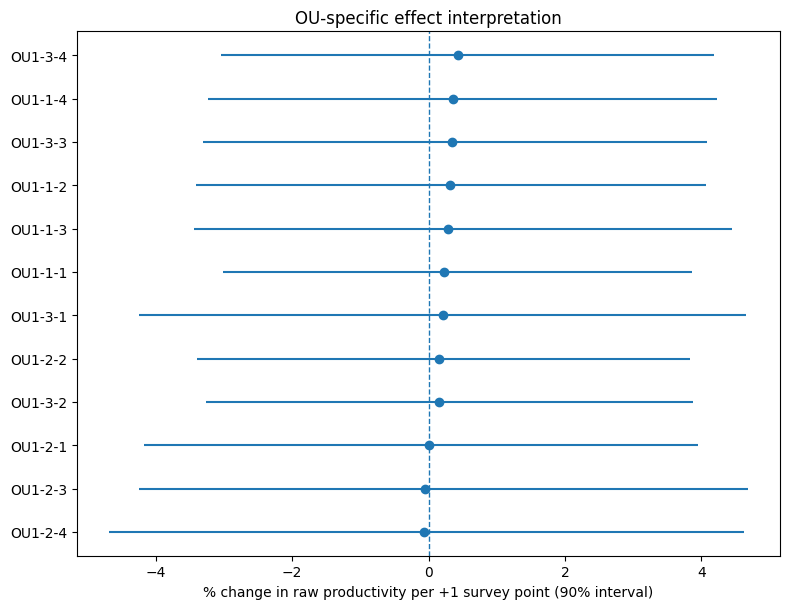

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, arviz as az
# assumes: idata, y_sd, x_sd, df, ou_labels already defined

# Pull posterior: dims ~ (chain, draw, beta_ou_dim_0)
beta = idata.posterior["beta_ou"]

# Map to % change in raw productivity per +1 survey point
mult = np.exp((y_sd / x_sd) * beta)
pct  = (mult - 1.0) * 100.0  # dims: (chain, draw, ou)

# Posterior mean & 90% interval over chain/draw
pct_mean = pct.mean(dim=("chain","draw")).values  # shape: (G,)
q = pct.quantile([0.05, 0.95], dim=("chain","draw"))          # dims: (quantile, ou)
pct_lo = q.sel(quantile=0.05).values
pct_hi = q.sel(quantile=0.95).values

eff_df = pd.DataFrame({
    "ou_code": pd.Index(pd.Categorical(df["ou_code"]).categories.astype(str)),
    "pct_mean": pct_mean, "pct_lo": pct_lo, "pct_hi": pct_hi
}).set_index("ou_code").sort_values("pct_mean")

display(eff_df)

# Plot interval per OU
fig, ax = plt.subplots(figsize=(8, 0.35*len(eff_df)+2))
ypos = np.arange(len(eff_df))
ax.hlines(y=ypos, xmin=eff_df["pct_lo"], xmax=eff_df["pct_hi"])
ax.plot(eff_df["pct_mean"], ypos, "o")
ax.axvline(0, ls="--", lw=1)
ax.set_yticks(ypos, eff_df.index)
ax.set_xlabel("% change in raw productivity per +1 survey point (90% interval)")
ax.set_title("OU-specific effect interpretation")
plt.tight_layout(); plt.show()

,mean,hdi_5%,hdi_95%
ou_code,,,
OU1-1-1,-0.351,-0.540,-0.125
OU1-1-2,-0.500,-0.655,-0.344
OU1-1-3,-1.231,-1.572,-0.902
OU1-1-4,-0.603,-0.793,-0.398
OU1-2-1,1.433,1.054,1.785
OU1-2-2,0.405,0.096,0.671
OU1-2-3,1.179,1.004,1.352
OU1-2-4,1.337,1.095,1.594
OU1-3-1,-0.773,-0.970,-0.592


,mean,hdi_5%,hdi_95%
ou_code,,,
OU1-1-1,0.023,-0.322,0.427
OU1-1-2,0.032,-0.398,0.410
OU1-1-3,0.029,-0.394,0.464
OU1-1-4,0.037,-0.335,0.475
OU1-2-1,-0.003,-0.482,0.402
OU1-2-2,0.015,-0.404,0.383
OU1-2-3,-0.009,-0.477,0.501
OU1-2-4,-0.011,-0.550,0.471
OU1-3-1,0.019,-0.452,0.514


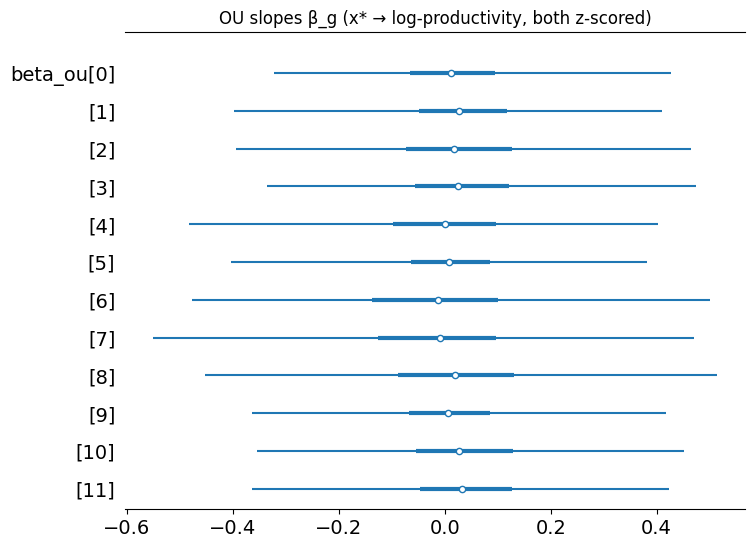

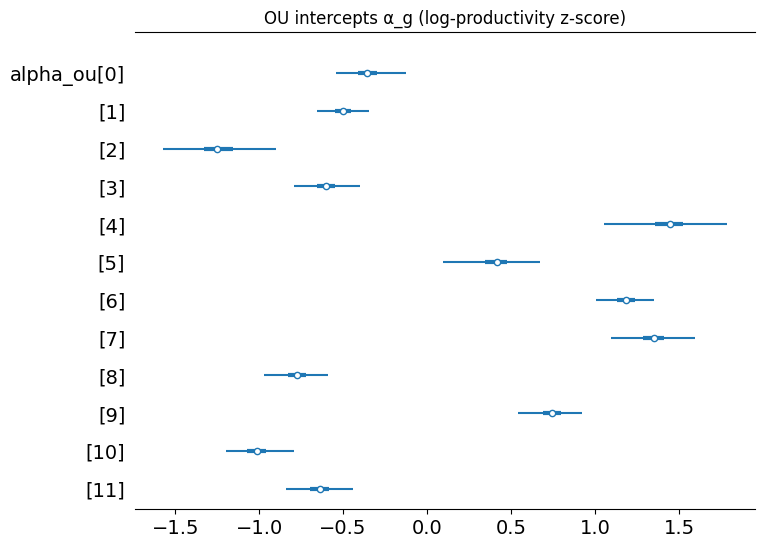

In [11]:
# Quick tables
summ_alpha = az.summary(idata, var_names=["alpha_ou"], hdi_prob=0.9)
summ_beta  = az.summary(idata, var_names=["beta_ou"],  hdi_prob=0.9)

def add_ou_labels(summ, labels):
    labs = []
    for idx in summ.index:
        i = int(idx.split("[")[1].rstrip("]"))
        labs.append(labels[i])
    return summ.assign(ou_code=labs).set_index("ou_code")

ou_labels = pd.Index(pd.Categorical(df["ou_code"]).categories.astype(str), name="ou_code")
display(add_ou_labels(summ_alpha, ou_labels)[["mean","hdi_5%","hdi_95%"]])
display(add_ou_labels(summ_beta,  ou_labels)[["mean","hdi_5%","hdi_95%"]])

# Forest plots
az.plot_forest(idata, var_names=["beta_ou"], combined=True, hdi_prob=0.9,
               figsize=(8, 0.35*len(ou_labels)+2))
plt.title("OU slopes β_g (x* → log-productivity, both z-scored)"); plt.show()

az.plot_forest(idata, var_names=["alpha_ou"], combined=True, hdi_prob=0.9,
               figsize=(8, 0.35*len(ou_labels)+2))
plt.title("OU intercepts α_g (log-productivity z-score)"); plt.show()

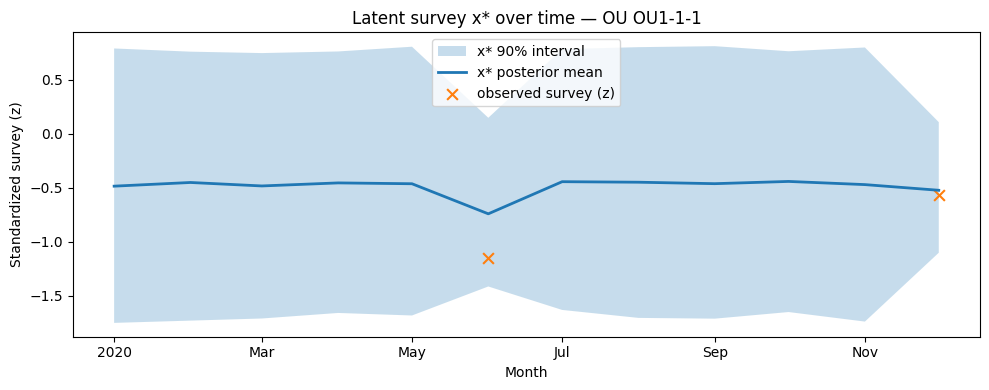

In [12]:
import matplotlib.dates as mdates

def plot_latent_for_ou(ou_code_str):
    labels = pd.Categorical(df["ou_code"]).categories.astype(str)
    g = int(np.where(labels == ou_code_str)[0][0])

    # rows for this OU, ordered in time
    row_idx_all = np.where(pd.Categorical(df["ou_code"]).codes == g)[0]
    t = time_idx[row_idx_all]
    order = np.argsort(t)
    row_idx = row_idx_all[order]
    months = pd.to_datetime(unique_months[t[order]])

    # posterior summaries for x_latent at those rows
    x_da  = idata.posterior["x_latent"]                     # (chain, draw, obs)
    x_mu  = x_da.mean(("chain","draw")).values[row_idx]
    qx    = x_da.quantile([0.05, 0.95], dim=("chain","draw"))
    lo    = qx.sel(quantile=0.05).values[row_idx]
    hi    = qx.sel(quantile=0.95).values[row_idx]

    # observed standardized survey at those rows
    obs_mask = has_survey[row_idx]
    obs_months = months[obs_mask]
    obs_vals   = x_z[row_idx][obs_mask]

    fig, ax = plt.subplots(figsize=(10,4))
    ax.fill_between(months, lo, hi, alpha=0.25, label="x* 90% interval")
    ax.plot(months, x_mu, lw=2, label="x* posterior mean")
    ax.scatter(obs_months, obs_vals, marker="x", s=60, label="observed survey (z)")
    ax.set_title(f"Latent survey x* over time — OU {ou_code_str}")
    ax.set_ylabel("Standardized survey (z)")
    ax.set_xlabel("Month")
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.tight_layout(); plt.show()

# Example
plot_latent_for_ou(str(ou_labels[0]))

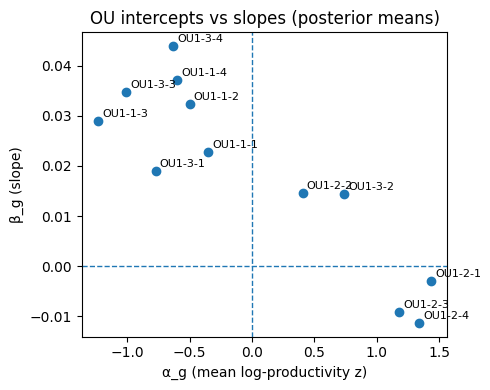

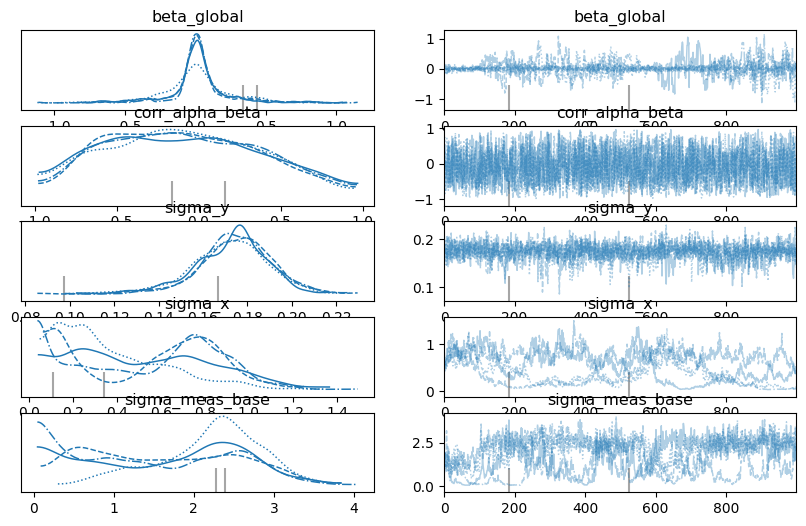

In [13]:
# Quick plot: OU intercept vs slope post means
a_mu = idata.posterior["alpha_ou"].mean(("chain","draw")).to_numpy()
b_mu = idata.posterior["beta_ou"].mean(("chain","draw")).to_numpy()

plt.figure(figsize=(5,4))
plt.scatter(a_mu, b_mu)
for i, lab in enumerate(ou_labels):
    plt.annotate(str(lab), (a_mu[i], b_mu[i]), fontsize=8, xytext=(3,3), textcoords="offset points")
plt.axhline(0, lw=1, ls="--"); plt.axvline(0, lw=1, ls="--")
plt.xlabel("α_g (mean log-productivity z)"); plt.ylabel("β_g (slope)")
plt.title("OU intercepts vs slopes (posterior means)")
plt.tight_layout(); plt.show()

# Some single-parameter posteriors
az.plot_trace(idata, var_names=["beta_global","corr_alpha_beta","sigma_y","sigma_x","sigma_meas_base"], compact=True, figsize=(10,6))
plt.show()

In [14]:
# import os
# os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ["PATH"]
# # Optional: be explicit
# os.environ["GRAPHVIZ_DOT"] = "/opt/homebrew/bin/dot"
# pm.model_to_graphviz(model)

In [15]:
g = pm.model_to_graphviz(model)
print(g.source[:1000])           # preview DOT text
g.save("model.dot")              # write DOT to file

digraph {
	sigma_x [label="sigma_x
~
Halfnormal" shape=ellipse]
	corr_alpha_beta [label="corr_alpha_beta
~
Deterministic" shape=box]
	mu_x [label="mu_x
~
Normal" shape=ellipse]
	sigma_meas_base [label="sigma_meas_base
~
Halfnormal" shape=ellipse]
	mu_alpha [label="mu_alpha
~
Normal" shape=ellipse]
	beta_global [label="beta_global
~
Deterministic" shape=box]
	sigma_y [label="sigma_y
~
Halfnormal" shape=ellipse]
	sigma_mu_x [label="sigma_mu_x
~
Halfnormal" shape=ellipse]
	mu_beta [label="mu_beta
~
Normal" shape=ellipse]
	subgraph cluster3 {
		L_ou [label="L_ou
~
_LKJCholeskyCov" shape=ellipse]
		label=3 labeljust=r labelloc=b style=rounded
	}
	subgraph "cluster2 x 2" {
		L_ou_corr [label="L_ou_corr
~
Deterministic" shape=box]
		label="2 x 2" labeljust=r labelloc=b style=rounded
	}
	subgraph cluster2 {
		L_ou_stds [label="L_ou_stds
~
Deterministic" shape=box]
		label=2 labeljust=r labelloc=b style=rounded
	}
	subgraph "cluster12 x 2" {
		z [label="z
~
Normal" shape=ellipse]
		label="12 x 

'model.dot'

In [17]:
import shutil, os 
print ("dot:", shutil.which("dot"))

dot: None


In [16]:

# ---- 5) Quick checks ----
az.summary(idata, var_names=[
    "mu_alpha", "mu_beta", "sigma_y", "sigma_x", "sigma_mu_x",
    "sigma_meas_base", "corr_alpha_beta"
], kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_alpha,-0.009,0.286,-0.533,0.554
mu_beta,0.018,0.217,-0.425,0.495
sigma_y,0.173,0.017,0.141,0.205
sigma_x,0.505,0.308,0.040,0.967
sigma_mu_x,0.642,0.266,0.120,1.137
sigma_meas_base,1.754,0.931,0.043,3.033
corr_alpha_beta,-0.086,0.457,-0.891,0.707
